In [1]:
import pm4py
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import tqdm
from project_functions import *
from datetime import timedelta
from workalendar.europe import Italy


Load dataset with pickle

In [2]:
log = None
with open("data/log_pm4py.pkl", "rb") as f:
    log = pickle.load(f)
log_df = pm4py.convert_to_dataframe(log)


# Variant analysis

In this section we analyze the variants and apply constraint to remove noise

In [3]:
start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)

print("Start activities: ", start_activities)
print("End activities: ", end_activities)

Start activities:  {'Create Fine': 150370}
End activities:  {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


As we previously identify, we have some problem with the end activities: the only accettable end activities are:
* Payment
* Send for credit collection

There are 2 other possibile end activities

* Send appeal to prefecture
* Appeal to judge

but this are accettable only if the appeal is win, that is when the dismissal attribut is set '#' (prefecture) or 'G' (judge)

## End activities

### Send fine as end activity

By looking at the frequencies of the non-compliant end activities, we can see that there is a problem with Send fine

In [4]:
send_fine_variants = pm4py.filter_end_activities(log_df, ["Send Fine"])

len(send_fine_variants['case:concept:name'].unique())

20755

One possibile explanation of this high number is the fact the fine was sent beyond the 90 days established by law, therefore invalidating it, let's check it

In [5]:
send_fine_variants_duration = send_fine_variants.groupby('case:concept:name').agg( Events=('case:concept:name','count') ,
                                                          FirstOccurence =('time:timestamp', lambda x:x.min()),
                                                          LastOccurence =('time:timestamp', lambda x:x.max()),
                                                          Duration =('time:timestamp', lambda x: x.max()-x.min()))

In [6]:

anomalies = send_fine_variants_duration[send_fine_variants_duration['Duration'] < timedelta(days=90)]
print("Number of cases with duration <90 days: ", len(anomalies))


Number of cases with duration <90 days:  8813


As we can see only 11'942 (20'755-8813) cases have an explanation for their behavior. For the remaining cases, since we don't have any documentation about it, we will consider them as anomalies and remove them.

In [7]:
#remove anomalies from log_df
log_df = log_df[~log_df['case:concept:name'].isin(anomalies.index)]
print("We now have",len(log_df['case:concept:name'].unique()),"cases")


We now have 141557 cases


### Appeals as end activities
As we mentioned earlier, a case can end with an appeal to the prefecture or the judge, if the 'Dismissal' field is not NIL

In [8]:
#Remove case with end activity "Send appeal to judge" and with dismissal != NIL
appeal_cases = pm4py.filter_end_activities(log_df, ["Send Appeal to Prefecture"])

dismissal = appeal_cases[appeal_cases['concept:name'] == 'Send Appeal to Prefecture']
dismissal = dismissal[dismissal['dismissal'] == 'NIL']
dismissal = dismissal['case:concept:name'].unique()

#remove appeal cases from log_df
log_df = log_df[~log_df['case:concept:name'].isin(dismissal)]


#Repeat for Appeal to Judge
appeal_cases = pm4py.filter_end_activities(log_df, ["Appeal to Judge"])

dismissal = appeal_cases[appeal_cases['concept:name'] == 'Appeal to Judge']
dismissal = dismissal[dismissal['dismissal'] == 'NIL']
dismissal = dismissal['case:concept:name'].unique()

#remove appeal cases from log_df
log_df = log_df[~log_df['case:concept:name'].isin(dismissal)]

print("We now have",len(log_df['case:concept:name'].unique()),"cases")


We now have 140315 cases


### Other end activities

In [9]:
other_end_variants = pm4py.filter_end_activities(log_df, ["Notify Result Appeal to Offender","Receive Result Appeal from Prefecture"])
print(len(other_end_variants['case:concept:name'].unique()))

139


All the cases that ends with 2 non-complaint end activitiy are just 139, hence we can consider them as noise and filter them out

In [10]:
#remove other_end_variants from log_df
log_df = log_df[~log_df['case:concept:name'].isin(other_end_variants['case:concept:name'])]
print("We now have",len(log_df['case:concept:name'].unique()),"cases")


We now have 140176 cases


# Filtering



## Duration based filtering

### Distribution of duration

Case duration for all cases.

Duration expressed in days.

In [11]:

case_durations = log_df.groupby('case:concept:name').agg( Events=('case:concept:name','count') ,
                                                          FirstOccurence =('time:timestamp', lambda x:x.min()),
                                                          LastOccurence =('time:timestamp', lambda x:x.max()),
                                                          Duration =('time:timestamp', lambda x: x.max()-x.min()))

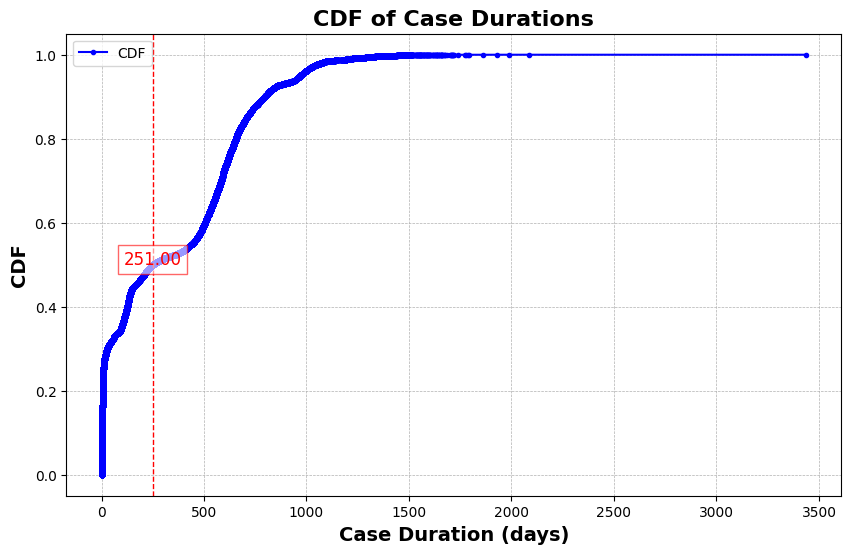

In [12]:
plot_cdf(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60)
, img_path="img/case_durations_cdf.png", title='CDF of Case Durations', xlabel='Case Duration (days)', ylabel='CDF')

Min max duration

In [13]:
#print min and max case duration
print(f"Min case duration: {case_durations['Duration'].min()}")
print(f"Max case duration: {case_durations['Duration'].max()}")

Min case duration: 0 days 00:00:00
Max case duration: 3437 days 00:00:00


In [14]:
#num of case with duration = 0
print(f"Number of cases with duration = 0: {case_durations[case_durations['Duration'] == pd.Timedelta(0)].shape[0]}")

Number of cases with duration = 0: 4802


### We now focus on cases with duration = 0

Filtering those 4920 cases with PMTK we get this sunburst plot

<img src="img/variants_sunburst.png" width="50%">

As we can see 98% of cases follow the same trace, create_fine -> payment, we can consider this cases as "manually" resolved by an operator. But since we cannot extract any information about the process we can discard this cases, as well for the 2% remaining that we just mark as noise.




## Applying constraints

Thanks to a little knowledge domain we know that some activities cannot be ancestors or discendant of other activities; therefore we can remove those cases which are non compliant with this following constraints:

* Receive Result Appeal from Prefecture cannot be ancestor of Send Appeal to Prefecture
* Send fine can only have Create fine as predecessor. 

In [15]:
variants = pm4py.get_variants(log_df)
anomalies = set()
count=0
for variant in variants:
    for i in range(len(variant)):
        
        
        if variant[i] == 'Send Fine':
            if variant[i-1] != 'Create Fine':
                anomalies.add(variant)
                count+= variants[variant]
        
        
        if variant[i] == 'Receive Result Appeal from Prefecture':
            for j in range(0,i,1):

                if variant[j] == 'Send Appeal to Prefecture':
                    anomalies.add(variant)
                    count+= variants[variant]
                    break
        
print(count)

#remove cases that follows anomalies trace from log_df
log_df = pm4py.filter_variants(log_df, anomalies, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp', retain=False)
print("We now have",len(log_df['case:concept:name'].unique()),"cases")


1030
We now have 139148 cases


Now let's serialize the filter df

In [16]:
with open("data/log_df_filtered.pkl", "wb") as f:
    pickle.dump(log_df, f)

# Statistics of the filtered log

We now have 134346 cases
25th percentile:  15 days 00:00:00
50th percentile:  318 days 00:00:00
75th percentile:  623 days 00:00:00
135374


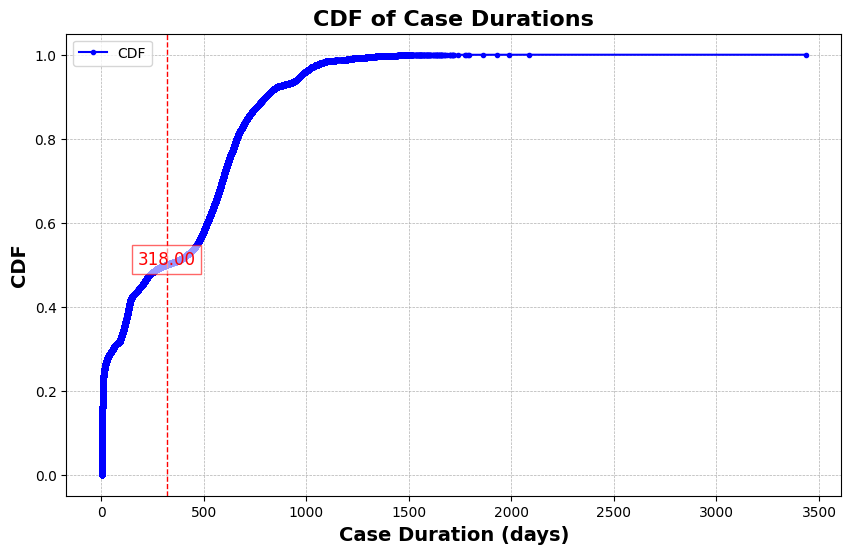

In [17]:
#remove the cases with duration = 0 from the log
log_df = log_df[~log_df['case:concept:name'].isin(case_durations[case_durations['Duration'] == pd.Timedelta(0)].index)]
print("We now have",len(log_df['case:concept:name'].unique()),"cases")

#remove those same cases from case_durations
case_durations = case_durations[case_durations['Duration'] > pd.Timedelta(0)]

#plot the cdf of the case duration
plot_cdf(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60)
, img_path="img/case_durations_over_0cdf.png", title='CDF of Case Durations', xlabel='Case Duration (days)', ylabel='CDF')

#print 20, 40, 60, 60, 80 precentiles
print("25th percentile: ", case_durations['Duration'].quantile(0.25))
print("50th percentile: ", case_durations['Duration'].quantile(0.50))
print("75th percentile: ", case_durations['Duration'].quantile(0.75))


print(len(case_durations))

Looking at the previous plot we can see that aboout 20% of cases are close to zero, so we now focus on those

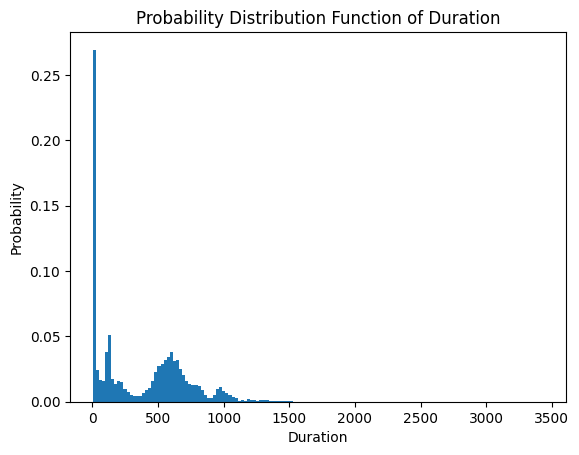

In [26]:

#PDF of the case duration. This is done to have a better view of that change of growth before the 500 days case duration

duration = case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60)
hist, bins = np.histogram(duration, bins='auto', density=True)
pdf = hist / np.sum(hist)

# Plot the PDF
plt.bar(bins[:-1], pdf, width=np.diff(bins), align='edge')
plt.xlabel('Duration')
plt.ylabel('Probability')
plt.title('Probability Distribution Function of Duration')
plt.show()

25th percentile: 15.0


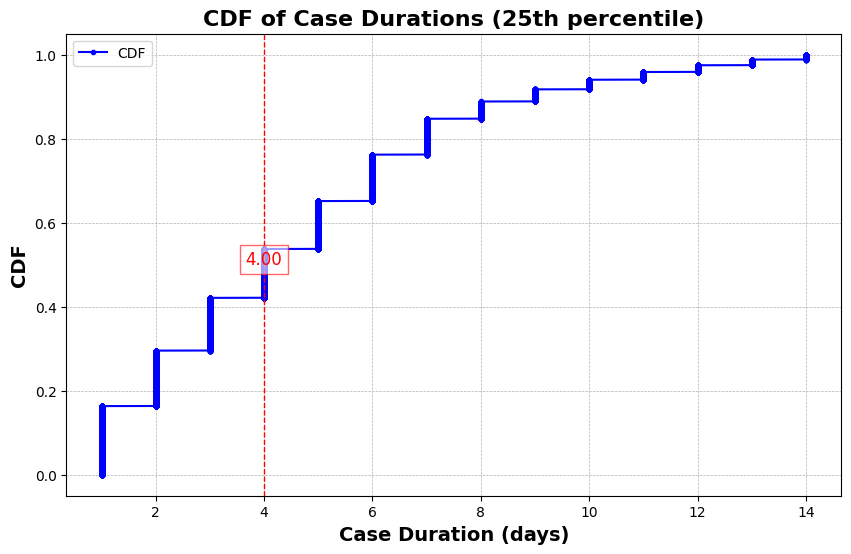

In [18]:
#get the 25 percentile
percentile_25 = np.percentile(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60), 25)
print(f"25th percentile: {percentile_25}")

#get cases with duration < 25th percentile
p25_cases = case_durations[case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60) < percentile_25]

plot_cdf(p25_cases['Duration'].dt.total_seconds() / (24 * 60 * 60), title='CDF of Case Durations (25th percentile)', img_path='img/short_case_cdf.png', xlabel='Case Duration (days)', ylabel='CDF')


In [19]:
p25_variants = pm4py.get_variants(log_df[log_df['case:concept:name'].isin(p25_cases.index)])
p25_variants

{('Create Fine', 'Payment'): 33685,
 ('Create Fine', 'Payment', 'Payment'): 3,
 ('Create Fine', 'Send Fine', 'Payment'): 3}

As expected the cases with lower duration has shorter variants, now let see the longest one

75th percentile: 623.0


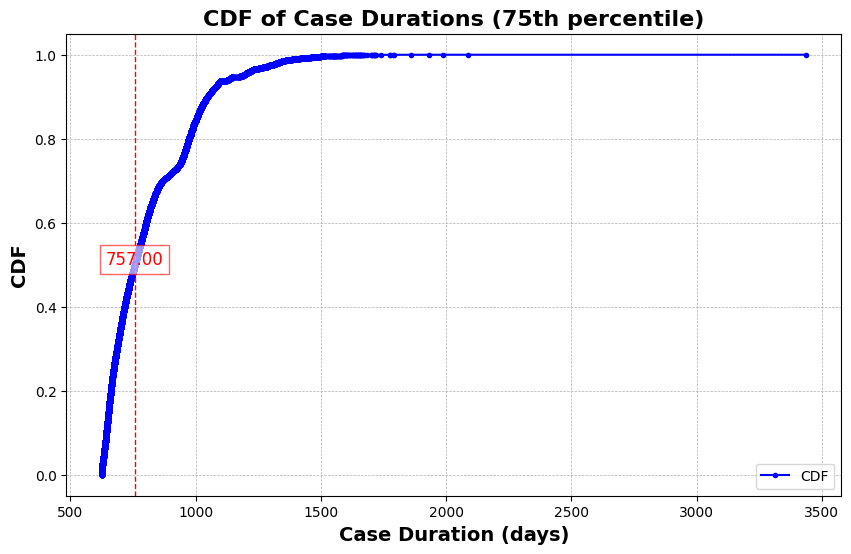

In [20]:
#get the 75 percentile
percentile_75 = np.percentile(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60), 75)
print(f"75th percentile: {percentile_75}")

#get cases with duration > 75th percentile
p75_cases = case_durations[case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60) > percentile_75]
plot_cdf(p75_cases['Duration'].dt.total_seconds() / (24 * 60 * 60), title='CDF of Case Durations (75th percentile)',img_path='img/long_case_cdf.png' ,xlabel='Case Duration (days)', ylabel='CDF')



In [21]:
p75_variants = pm4py.get_variants(log_df[log_df['case:concept:name'].isin(p75_cases.index)])
p75_variants

{('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Send for Credit Collection'): 30533,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment',
  'Send for Credit Collection'): 755,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment'): 1354,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment',
  'Payment'): 192,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Insert Date Appeal to Prefecture',
  'Receive Result Appeal from Prefecture',
  'Notify Result Appeal to Offender',
  'Payment',
  'Payment'): 2,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Appeal to Judge',
  'Add penalty',
  'Payment'): 69,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Appeal to Judge',
  'Add penalty',
  'Send for Credit Collection'): 101,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notificati

In [30]:
len(case_durations[case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60) > percentile_75])

33717

In the situation of the longest cases we have that most of all includes the 'Send for Credit Collection' activity. 
This investigation highlight two points:
* When the credit collection is involved the duration of cases is much higher
* The juridical part (making an appeal) does not slow down the process as much the credit collection does.

There is a possible explanation behind the duration being extend with the credit collection. We use the PMTK dotted chart to have a view of what is happening.

<img src='img/Dotted_chart.png'>

The <span style='color:red'> red dots </span> represent the activity 'Send for credit collection'. We can see how this has an annual cadence, generally the end of the year. So each case (that needs credit collection) must necessarily wait until the day of the year when the credit fine collection is set, in order to close the procedure. 

We can make two more comment on this chart:
* The <span style='color:pink'> pink dots </span> represent the activity 'Payment', here we can see that the payments are more frequent some days before the date set for the credit collection. This is just an assumption and this event can be caused by some other factors, unfortunately, not having a proper documentation blocks us to explain every behavior.
* On 2012 something happen with the 'Send appeal to prefecture', represented by the  <span style='color:orange'> orange dots </span>, all of this activites are set on 25th of december 2012. Again, not having a proper documentation don't help us in explain this event.